In [38]:
import pandas as pd
import yfinance as yf
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from matplotlib import rcParams
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.dates as mdates
# import ace_tools as tools; 

# 配置中文字体
plt.rcParams['font.family'] = 'Heiti TC'

# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.dpi'] = 150
plt.rcParams.update({'font.size': 12})

In [39]:
def get_stock_data(stock_symbols, start_date, end_date):
    stock_data = {}
    for symbol in stock_symbols:
        stock_data[symbol] = yf.download(symbol, start=start_date, end=end_date)
    return stock_data

def get_stock_price(stock_symbols, start_date, end_date):
    stock_data = {}
    for symbol in stock_symbols:
        stock_data[symbol] = yf.download(symbol, start=start_date, end=end_date)['Adj Close']
    return pd.DataFrame(stock_data)

def calculate_moving_average(stock_prices, short_window, long_window):
    short_ma = stock_prices.rolling(window=short_window).mean()
    long_ma = stock_prices.rolling(window=long_window).mean()
    return short_ma, long_ma

# Calculate Z-score for mean reversion
def calculate_z_score(stock_prices, window):
    rolling_mean = stock_prices.rolling(window=window).mean()
    rolling_std = stock_prices.rolling(window=window).std()
    z_score = (stock_prices - rolling_mean) / rolling_std
    return z_score

# Adjust Threshold Dynamically
def dynamic_threshold(SSINDX, window):
    std_SSINDX = (SSINDX - SSINDX.mean())/SSINDX.std()
    rolling_std = std_SSINDX.rolling(window).std()
    return 2.0 + 2 * rolling_std

# Portfolio optimization
def portfolio_optimization(returns, cov_matrix):
    num_assets = len(returns)

    def objective(weights):
        return np.dot(weights.T, np.dot(cov_matrix, weights))
    
    def constraint(weights):
        return np.sum(weights) - 1

    cons = ({'type': 'eq', 'fun': constraint})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(objective, num_assets * [1. / num_assets,], bounds=bounds, constraints=cons)
    
    return result.x

# Calculate max drawdown
def calculate_max_drawdown(portfolio_values):
    cumulative_max = np.maximum.accumulate(portfolio_values)
    drawdown = (cumulative_max - portfolio_values) / cumulative_max
    max_drawdown = np.max(drawdown) * 100
    return max_drawdown

def calculate_turnover(positions, stock_prices):
    """
    Calculate the turnover ratio based on position changes and stock prices.
    
    Parameters:
    - positions: DataFrame or array where each row represents the positions of all assets at a given time
    - stock_prices: DataFrame or array of stock prices corresponding to positions
    
    Returns:
    - turnovers: The average turnover ratio over all periods
    """
    # 计算每个时间段的市值变化
    portfolio_values = positions[1:] * stock_prices[window:]
    weight_changes = np.abs(portfolio_values.diff()).dropna()
    
    # 计算每个时间段的总权重变化
    turnovers = weight_changes.sum(axis=1) / portfolio_values.sum(axis=1).shift(1)
    
    return turnovers.mean()  # 返回平均Turnover

# Summarize PnL analysis
def pnl_summary(portfolio_values, dates, buy_count, sell_count):
    df = pd.DataFrame({'Date': dates, 'Portfolio Value': portfolio_values})
    df.set_index('Date', inplace=True)
    df['Return'] = df['Portfolio Value'].pct_change()
    df['Year'] = df.index.year

    summary = df.groupby('Year').agg({
        'Portfolio Value': ['first', 'last'],
        'Return': ['std']
    })
    summary.columns = ['Start Value', 'End Value', 'Return Std']
    summary['Annual Return %'] = ((summary['End Value'] / summary['Start Value']) - 1) * 100
    summary['Sharpe Ratio'] = summary['Annual Return %']  / (summary['Return Std'] * np.sqrt(252) * 100)
    
    # Calculate Max Drawdown per year
    max_drawdowns = []
    for year in summary.index:
        year_values = df[df['Year'] == year]['Portfolio Value']
        max_drawdowns.append(calculate_max_drawdown(year_values.values))

    summary['Max Drawdown %'] = max_drawdowns
    summary['Buy Count'] = buy_count
    summary['Sell Count'] = sell_count
    
    # Round to 2 decimal places
    summary = summary.round(2)

    return summary

# Summarize total PnL analysis
def pnl_summary_total(portfolio_values, dates, positions, stock_prices):
    df = pd.DataFrame({'Date': dates, 'Portfolio Value': portfolio_values})
    df.set_index('Date', inplace=True)
    df['Return'] = df['Portfolio Value'].pct_change()
    
    # 计算投资总年数
    num_years = (dates[-1] - dates[0]).days / 365.0
    # 计算回报率
    total_return = ((df['Portfolio Value'].iloc[-1] / df['Portfolio Value'].iloc[0]) - 1) * 100
    # 计算总体年化回报率
    returns = (df['Portfolio Value'].iloc[-1]/df['Portfolio Value'].iloc[0]) ** (1/num_years) - 1
    # 计算夏普比率
    sharpe_ratio = df['Return'].mean() / df['Return'].std() * np.sqrt(252)
    # 计算最大回撤
    max_drawdown = calculate_max_drawdown(df['Portfolio Value'].values)
    # 计算Turnover
    turnover = calculate_turnover(positions, stock_prices)
    # 计算Fitness
    fitness = sharpe_ratio * np.sqrt(np.abs(returns)/np.maximum(turnover, 0.125))

    summary_total = pd.DataFrame({
        'Total Return %': [np.round(total_return, 2)],
        'Annualized Return %': [np.round(returns * 100, 2)],
        'Sharpe Ratio': [sharpe_ratio],
        'Max Drawdown %': [max_drawdown],
        'Turnover %': [np.round(turnover * 100, 2)],
        'Fitness': [np.round(fitness, 2)]
    })

    # Round to 2 decimal places
    summary_total = summary_total.round(2)

    return summary_total

In [40]:
#### 按照排序分配权重的策略
# 初始分配权重
def initial_weights(stock_symbols):
    num_stocks = len(stock_symbols)
    return np.ones(num_stocks) / num_stocks

# 重新分配权重
def rebalance_weights(z_scores, date, initial_weight):
    ranked_stocks = z_scores.loc[date].sort_values()
    num_stocks = len(ranked_stocks)
    new_weights = np.zeros(num_stocks)
    
    # 根据排序结果重新分配权重
    for i, stock in enumerate(ranked_stocks.index):
        new_weights[i] = initial_weight * (1 + ranked_stocks.index.get_loc(stock) / num_stocks)
    new_weights /= new_weights.sum()  # 归一化权重

    return new_weights

def rebalance_rank_portfolio(stock_prices, window, initial_capital):
    transaction_cost=0.005
    lot_size=100
    min_trade_volume = 200
    z_scores = calculate_z_score(stock_prices, window)
    
    num_stocks = len(stock_prices.columns)
    initial_weight = 1 / num_stocks
    weights = initial_weights(stock_prices.columns)
    portfolio_value = initial_capital
    portfolio_values = [initial_capital]
    positions = np.zeros(num_stocks)
    positions = np.zeros((len(stock_prices.index[window-1:]), num_stocks))  # 存储每个交易日的仓位
    adjustments = np.zeros_like(positions)  # 存储每个交易日的调整信号
    current_positions = np.zeros(num_stocks)
    positions[0] = current_positions
    cash = initial_capital
    buy_count = []
    sell_count = []
    annual_buy_count = 0
    annual_sell_count = 0
    current_year = stock_prices.index[window].year

    for t, date in enumerate(stock_prices.index[window:], start=1):
        if date.year != current_year:
            buy_count.append(annual_buy_count)
            sell_count.append(annual_sell_count)
            annual_buy_count = 0
            annual_sell_count = 0
            current_year = date.year
        
        # 根据Z-score排序重新分配权重
        new_weights = rebalance_weights(z_scores, date, initial_weight)
        
        # 根据新的权重进行买卖股票
        for i, stock in enumerate(stock_prices.columns):
            current_price = stock_prices[stock].loc[date]
            desired_position = portfolio_value * new_weights[i] // current_price
            
            # 检查交易量是否达到最低交易量限制
            trade_volume = abs(desired_position - current_positions[i]) * current_price
            if trade_volume < min_trade_volume:
                continue  # 如果交易量小于最低限制，则跳过此交易
            
            if desired_position > current_positions[i]:
                buy_amount = (desired_position - current_positions[i]) // lot_size * lot_size
                if buy_amount > 0 and cash >= buy_amount * current_price * (1 + transaction_cost):
                    current_positions[i] += buy_amount
                    cash -= buy_amount * current_price * (1 + transaction_cost)
                    annual_buy_count += 1
            elif desired_position < current_positions[i]:
                sell_amount = (current_positions[i] - desired_position) // lot_size * lot_size
                if sell_amount > 0:
                    current_positions[i] -= sell_amount
                    cash += sell_amount * current_price * (1 - transaction_cost)
                    annual_sell_count += 1

        weights = new_weights
        portfolio_value = cash + np.sum(current_positions * stock_prices.loc[date])
        portfolio_values.append(portfolio_value)
        positions[t] = current_positions  # 记录仓位
        
    buy_count.append(annual_buy_count)
    sell_count.append(annual_sell_count)

    return portfolio_values, weights, positions, adjustments, buy_count, sell_count

In [41]:

def rebalance_portfolio(stock_prices, SSINDX, window, initial_capital, short_ma=None, long_ma=None):
    lot_size=100
    transaction_cost = 0.005
    min_trade_volume = 100
    
    num_stocks = len(stock_prices.columns)
    z_scores = calculate_z_score(stock_prices, window)
    cov_matrix = stock_prices.pct_change().cov()
    mean_returns = stock_prices.pct_change().mean()
    dynamic_thresholds = dynamic_threshold(SSINDX, window)

    weights = portfolio_optimization(mean_returns, cov_matrix)
    portfolio_value = initial_capital
    portfolio_values = [initial_capital]
    positions = np.zeros((len(stock_prices.index[window-1:]), num_stocks))  # 存储每个交易日的仓位
    adjustments = np.zeros_like(positions)  # 存储每个交易日的调整信号
    current_positions = np.zeros(num_stocks)
    cash = initial_capital
    buy_count = []
    sell_count = []
    annual_buy_count = 0
    annual_sell_count = 0
    current_year = stock_prices.index[window].year
    
    positions[0] = current_positions

    for t, date in enumerate(stock_prices.index[window:], start=1):
        # 获取当前交易日的动态阈值
        threshold = dynamic_thresholds.loc[date]
        if date.year != current_year:
            buy_count.append(annual_buy_count)
            sell_count.append(annual_sell_count)
            annual_buy_count = 0
            annual_sell_count = 0
            current_year = date.year
        
        # 根据Z-score和趋势调整权重
        new_weights = np.zeros(len(weights))
        for i, stock in enumerate(stock_prices.columns):
            if short_ma[stock].loc[date] > long_ma[stock].loc[date]:  # 确保在多头市场
                if z_scores[stock].loc[date] < -threshold:
                    new_weights[i] = weights[i] + 0.01
                elif z_scores[stock].loc[date] > threshold:
                    new_weights[i] = weights[i] - 0.01
                else:
                    new_weights[i] = weights[i]
            else:
                new_weights[i] = weights[i]  # 保持不变
                
        
        new_weights = np.clip(new_weights, 0, 1)
        new_weights = new_weights / np.sum(new_weights)
        
        # 根据新的权重进行买卖股票
        for i, stock in enumerate(stock_prices.columns):
            current_price = stock_prices[stock].loc[date]
            desired_position = portfolio_value * new_weights[i] // current_price
            
            # 检查交易量是否达到最低交易量限制
            trade_volume = abs(desired_position - current_positions[i]) * current_price
            if trade_volume < min_trade_volume:
                continue  # 如果交易量小于最低限制，则跳过此交易
            
            if desired_position > current_positions[i]:
                buy_amount = (desired_position - current_positions[i]) // lot_size * lot_size
                if buy_amount > 0 and cash >= buy_amount * current_price * (1 + transaction_cost):
                    current_positions[i] += buy_amount
                    cash -= buy_amount * current_price * (1 + transaction_cost)
                    annual_buy_count += 1
                    adjustments[t, i] = 1 # 买入信号
            elif desired_position < current_positions[i]:
                sell_amount = (current_positions[i] - desired_position) // lot_size * lot_size
                if sell_amount > 0:
                    current_positions[i] -= sell_amount
                    cash += sell_amount * current_price * (1 - transaction_cost)
                    annual_sell_count += 1
                    adjustments[t, i] = -1  # 卖出信号
            else: adjustments[t, i] = 0  # 卖出信号
    
        weights = new_weights
        portfolio_value = cash + np.sum(current_positions * stock_prices.loc[date])
        portfolio_values.append(portfolio_value)
        positions[t] = current_positions  # 记录仓位
    
    buy_count.append(annual_buy_count)
    sell_count.append(annual_sell_count)

    return portfolio_values, weights, positions, adjustments, buy_count, sell_count


In [42]:
# 读取Excel文件
df = pd.read_excel('Stocks.xlsx', sheet_name='Holdlist')

# 获取股票代码列表
stock_symbols = df['Stock Symbol'].tolist()
stock_names = df['Stock Name'].tolist()

# 定义时间范围
start_date = '2022-01-01'
end_date = '2024-08-15'

# 设置参数
initial_capital = 40000
window = 10
threshold = 2.5
transaction_cost = 0.005  # 假设交易成本为0.5%
rebalance_period = 7  # 调仓周期为3天

stock_data = get_stock_price(stock_symbols, start_date, end_date)
# stock_data = get_stock_price()
# 获取上证指数数据
SSINDX = yf.download('000001.SS', start_date, end_date)['Close']

# Ensure stock_data is a DataFrame and handle any missing values
stock_prices = pd.DataFrame(stock_data).ffill().bfill()
dates = stock_prices.index[window-1:]
short_window = 40
long_window = 200
short_ma, long_ma = calculate_moving_average(stock_prices, short_window, long_window)

# 调整rebalance_portfolio函数的调用
portfolio_values, weights, positions, adjustments, buy_count, sell_count = rebalance_portfolio(stock_prices, SSINDX, window, initial_capital, short_ma, long_ma)
portfolio_values1, weights1, positions1, adjustments1, buy_count1, sell_count1 = rebalance_rank_portfolio(stock_prices=stock_prices, window=window, initial_capital=initial_capital)
benchmark = SSINDX / SSINDX.iloc[0] * portfolio_values[0]
print(f'Final Portfolio Value: {portfolio_values[-1]}')
print(f'Final Portfolio Value: {portfolio_values1[-1]}')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Final Portfolio Value: 63679.74217095971
Final Portfolio Value: 63163.78243941069


In [43]:
# Total PnL Summary
summary_total = pnl_summary_total(portfolio_values, dates, positions, stock_prices)
summary_total

,Total Return %,Annualized Return %,Sharpe Ratio,Max Drawdown %,Turnover %,Fitness
0,59.2,19.79,1.31,10.93,1.57,1.65


In [44]:
summary_total1 = pnl_summary_total(portfolio_values1, dates, positions1, stock_prices)
summary_total1

,Total Return %,Annualized Return %,Sharpe Ratio,Max Drawdown %,Turnover %,Fitness
0,57.91,19.41,1.21,10.55,1.52,1.51


In [45]:
# PnL Summary of Portfolio Optimization
summary = pnl_summary(portfolio_values, dates, buy_count, sell_count)
summary

,Start Value,End Value,Return Std,Annual Return %,Sharpe Ratio,Max Drawdown %,Buy Count,Sell Count
Year,,,,,,,,
2022,40000.00,43406.74,0.01,8.52,0.50,10.09,82,34
2023,43924.08,51809.97,0.01,17.95,1.61,5.50,84,49
2024,52502.19,63679.74,0.01,21.29,1.22,10.93,80,59


In [46]:
# PnL Summary of Rank Method
summary1 = pnl_summary(portfolio_values1, dates, buy_count1, sell_count1)
summary1

,Start Value,End Value,Return Std,Annual Return %,Sharpe Ratio,Max Drawdown %,Buy Count,Sell Count
Year,,,,,,,,
2022,40000.00,43273.90,0.01,8.18,0.45,10.25,43,5
2023,43811.54,49970.15,0.01,14.06,1.22,5.57,6,11
2024,50636.73,63163.78,0.01,24.74,1.28,10.55,26,19


### PnL Visualization

In [47]:
# Interactive Plot for Portfolio Value
fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y=portfolio_values, mode='lines', name='Portfolio Value'))
fig.add_trace(go.Scatter(x=dates, y=benchmark, mode='lines',name='SSINDX PnL'))
fig.update_layout(title='Portfolio Value Over Time', xaxis_title='Date', yaxis_title='Portfolio Value', hovermode='x unified')
fig.show()

In [48]:
# Interactive Plot for Portfolio Value
fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y=portfolio_values1, mode='lines', name='Portfolio Value'))
fig.add_trace(go.Scatter(x=dates, y=benchmark, mode='lines',name='SSINDX PnL'))
fig.update_layout(title='Portfolio Value Over Time', xaxis_title='Date', yaxis_title='Portfolio Value', hovermode='x unified')
fig.show()

### Visualization

In [49]:
# 历史仓位的堆积面积图
def plot_historical_positions(dates, positions, stock_names, stock_prices):
    dates = dates[1:]
    # 计算每个股票价值
    stock_values = positions[1:] * stock_prices[window:]
    # print(stock_values)
    
    # 计算总资产
    total_portfolio_value = stock_values.sum(axis=1).values.reshape(-1, 1)  # 移除 keepdims 并调整形状
    
    # 计算每个股票在总资产中的权重
    positions_weight = stock_values / total_portfolio_value * 100
   # 累积求和以形成堆积图效果
    cumulative_weights = np.cumsum(positions_weight, axis=1)
    fig = go.Figure()

    # 创建堆积面积图
    for i, stock in enumerate(stock_names):
        fig.add_trace(go.Scatter(
            x=dates,
            y=cumulative_weights.iloc[:, i],
            mode='none',  # 不显示线，只显示堆积部分
            fill='tonexty' if i > 0 else 'tozeroy',  # 第一个是从零开始填充，后面的堆积在前面的基础上
            name=stock,
            hoverinfo='text',  # 使用自定义的 hover 信息
            text=[f"{stock}: {p:.2f}%" for p in positions_weight.iloc[:, i]],  # 生成每个点的具体信息
            hovertemplate="%{text}<extra></extra>"  # 显示自定义的文本信息
        ))
    
    fig.update_layout(
        title="Historical Stock Positions Over Time",
        xaxis_title="Date",
        yaxis_title="Position Percentage (%)",
        yaxis=dict(range=[0, 100]),  # 确保Y轴从0到100%
        showlegend=True,
        hovermode="x unified"  # 使得悬停时显示统一的标签框
    )
    
    fig.show()
    
# 当前仓位的饼图
def plot_current_positions(weights, stock_names, threshold=0.03):
    # 合并小份额
    other_weight = 0
    filtered_weights = []
    filtered_symbols = []
    for weight, symbol in zip(weights, stock_names):
        if weight < threshold:
            other_weight += weight
        else:
            filtered_weights.append(weight)
            filtered_symbols.append(symbol)
    
    if other_weight > 0:
        filtered_weights.append(other_weight)
        filtered_symbols.append("Other")
    
    fig = go.Figure(data=[go.Pie(
        labels=filtered_symbols,
        values=filtered_weights,
        textinfo='label+percent',
        hoverinfo='label+percent+value',
        textfont=dict(size=12),
        hole=0.3  # 如果你想要甜甜圈图效果
    )])
    
    fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
    
    fig.update_layout(
        title_text="Current Portfolio Positions",
        annotations=[dict(text='Portfolio', x=0.5, y=0.5, font_size=15, showarrow=False)]
    )
    
    fig.show()
  
# 仓位调整提示的热力图
def plot_adjustment_heatmap(dates, adjustments, stock_names):
    disp_dates = pd.to_datetime(dates[-30:])
    disp_adjustments = adjustments[-30:]
    
    # 设置图像大小
    plt.figure(figsize=(12, 8))
    # 创建热力图
    sns.heatmap(disp_adjustments.T, cmap="coolwarm", center=0, linewidths=0.1, linecolor='black', 
                cbar_kws={'label': 'Adjustment Signal'}, yticklabels=stock_names, xticklabels=disp_dates.strftime('%m-%d'))
    
    plt.title("Position Adjustment Signals Over Last 30 Days")
    plt.xlabel("Date")
    plt.ylabel("Stock Symbol")
   
    plt.show()
    
# 仓位调整表格
def display_position_table(stock_names, positions, stock_prices, adjustments):
    current_stock_val = positions[-1] * stock_prices.iloc[-1]
    previous_stock_val = positions[-2] * stock_prices.iloc[-2]
    total_current = current_stock_val.sum(axis=0)
    total_previous = previous_stock_val.sum(axis=0)
    
    current_weights = current_stock_val / total_current
    previous_weights = previous_stock_val / total_previous
    weight_changes = (current_weights - previous_weights) * 100
    data = {
        'Stock Name': stock_names,
        'Previous Weight (%)': np.round(previous_weights * 100, 2),
        'Current Weight (%)': np.round(current_weights * 100, 2),
        'Adjustment Signal': adjustments[-1],
        'Weight Change (%)': np.round(weight_changes, 2)
    }
    df = pd.DataFrame(data)
    return df   

In [50]:
plot_historical_positions(dates, positions, stock_names, stock_prices)

In [51]:
plot_historical_positions(dates, positions1, stock_names, stock_prices)

In [52]:
plot_current_positions(weights, stock_names)

In [53]:
plot_current_positions(weights1, stock_names)

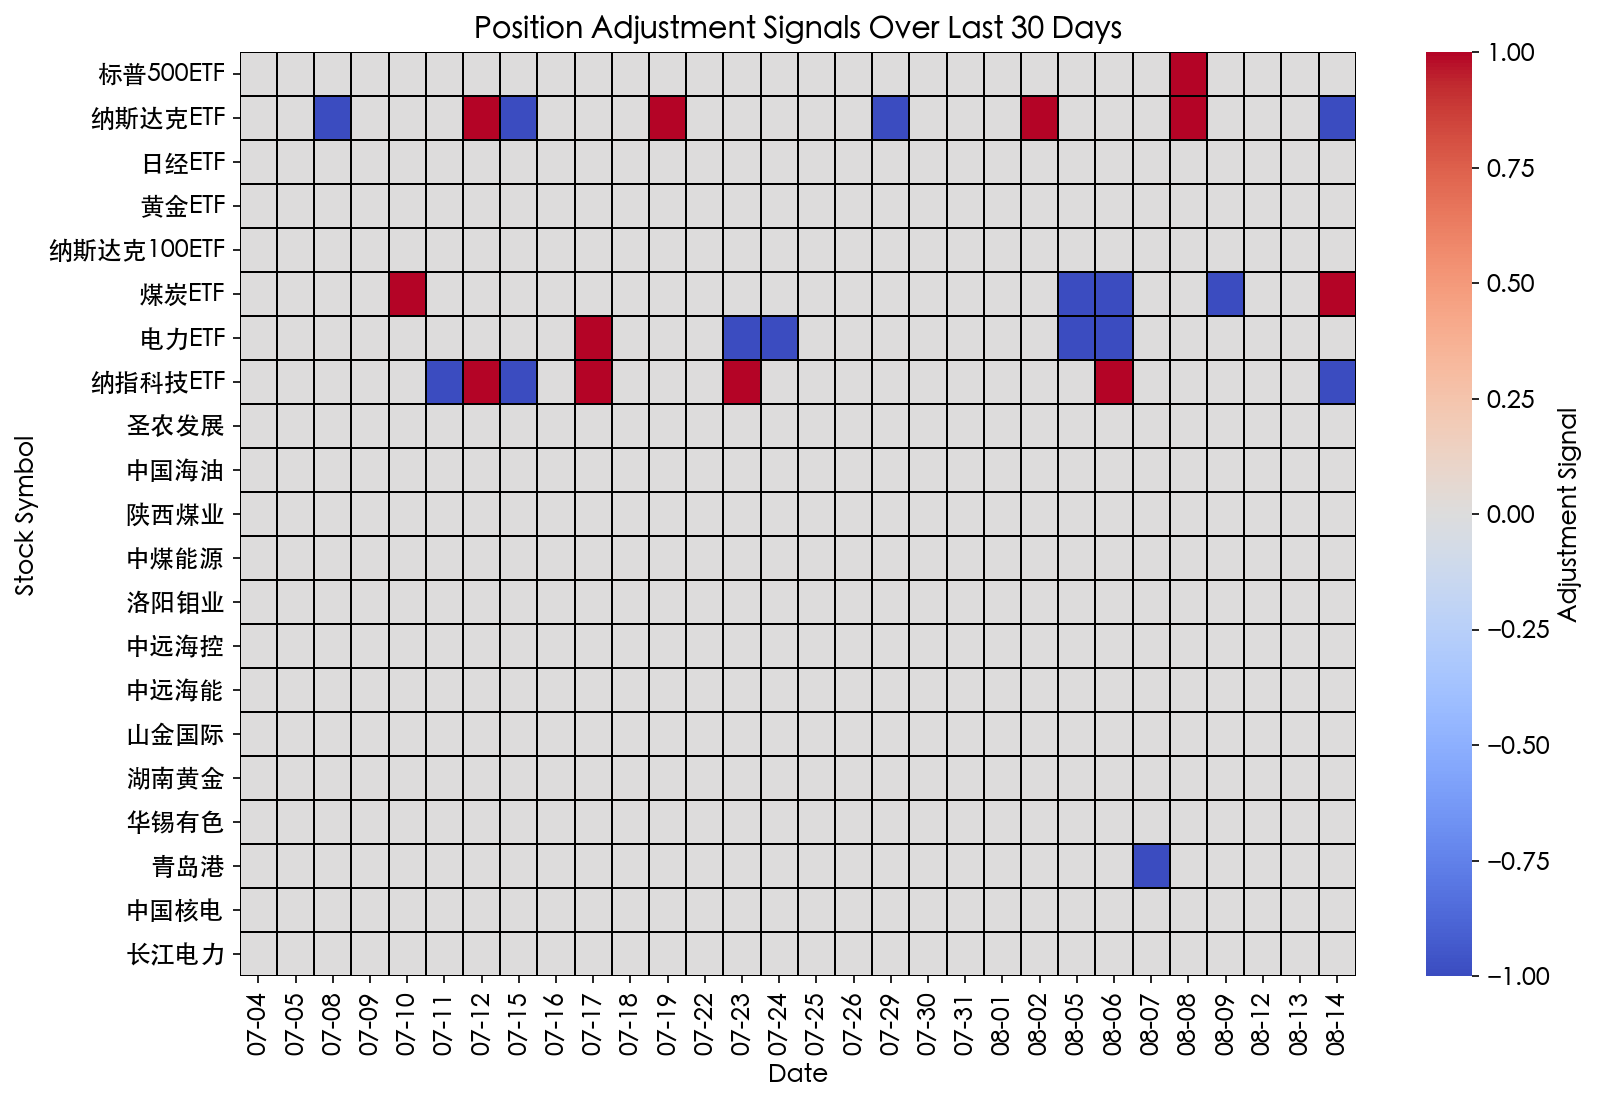

In [54]:
plot_adjustment_heatmap(dates, adjustments, stock_names)

In [55]:
position_table = display_position_table(stock_names, positions, stock_prices, adjustments)
print(dates[-1])
print(f'今日盈亏：{round(portfolio_values[-1] - portfolio_values[-2], 2)}, 盈亏比例：{round((portfolio_values[-1] - portfolio_values[-2])/portfolio_values[-1] * 100, 2)}%')
position_table

2024-08-14 00:00:00
今日盈亏：227.69, 盈亏比例：0.36%


,Stock Name,Previous Weight (%),Current Weight (%),Adjustment Signal,Weight Change (%)
513500.SS,标普500ETF,5.07,5.17,0.0,0.09
513300.SS,纳斯达克ETF,9.42,9.35,-1.0,-0.07
513520.SS,日经ETF,2.20,2.23,0.0,0.04
518880.SS,黄金ETF,1.73,1.73,0.0,-0.01
513110.SS,纳斯达克100ETF,5.39,5.48,0.0,0.09
515220.SS,煤炭ETF,4.95,5.05,1.0,0.10
159611.SZ,电力ETF,5.57,5.62,0.0,0.05
159509.SZ,纳指科技ETF,8.66,8.73,-1.0,0.07
002299.SZ,圣农发展,6.22,6.12,0.0,-0.10
600938.SS,中国海油,0.00,0.00,0.0,0.00
